In [21]:
import scale.olm
import pathlib
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# Load a reactor library.
path = pathlib.Path('/Users/ww5/olm/collection/w17x17/_work/arpdata.txt')
name = 'w17x17'
rl = scale.olm.core.ReactorLibrary(path,name)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 162.63it/s]


In [23]:
# Understand the axes.
print(rl.axes_names)
print(rl.axes_shape)
print(rl.axes_values)

['enrichment' 'mod_dens' 'times']
[2 2 3]
[array([4. , 8.5]), array([0.723  , 0.75915]), array([    0., 39000., 84000.], dtype=float32)]


In [24]:
# You need these environment variables corresponding to your setup. This happens after you run
# olm create config.olm.json to generate the work directory with its files.
_env={
    "config_file": "/Users/ww5/olm/collection/w17x17/config.olm.json",
    "work_dir": "/Users/ww5/olm/collection/w17x17/_work",
    "scalerte": "/Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte",
    "obiwan": "/Applications/SCALE-6.3.2.app/Contents/Resources/bin/obiwan",
    "nprocs": 3
}
_model={
    "name":"w17x17",
    "description":"Library Westinghouse 17x17 design",
    "sources":{
        
    },
    "revision":[
        "1.0"
    ],
    "notes":[
        
    ]
}

2024-10-30 08:12:39 [info     ] check LowOrderConsistency      template_file=/Users/ww5/olm/scale/olm/templates/model/origami/system-uox.jt.inp
2024-10-30 08:12:40 [info     ] Running SCALE                  version=6.3.2
2024-10-30 08:12:40 [info     ] Running external               command_line=cd /Users/ww5/olm/collection/w17x17/_work/check/check1 && make -j 3
2024-10-30 08:12:40 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0400w0723/w17x17_e0400w0723.inp
2024-10-30 08:12:40 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0850w0723/w17x17_e0850w0723.inp
2024-10-30 08:12:51 [info     ]                               
2024-10-30 08:12:51 [info     ] Running external               command_line=/Applications/SCALE-6.3.2.app/Contents/Resources/bin/obiwan view -format=ii.json /Users/ww5/olm/collection/w17x17/_work/check/check1/w17x17_e0400w0723/w17x17_e0400w0723.f71 -cases='[1]'
2024-10-30 08:12:51 [info     ] Running ex

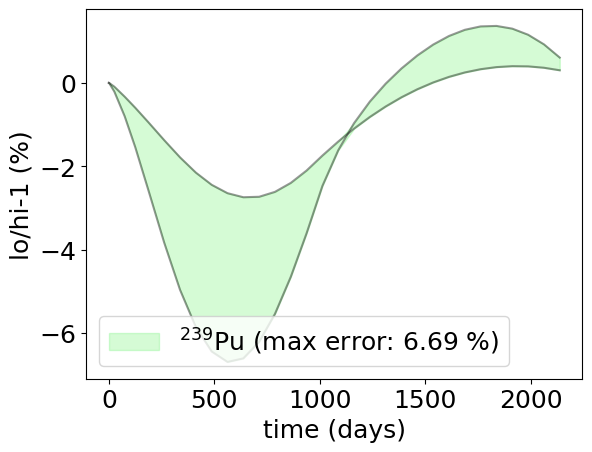

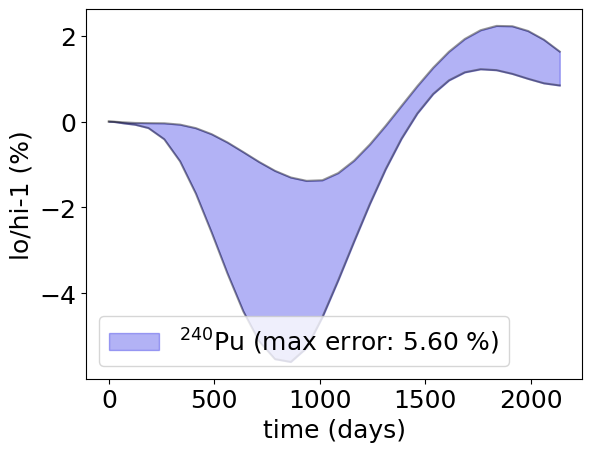

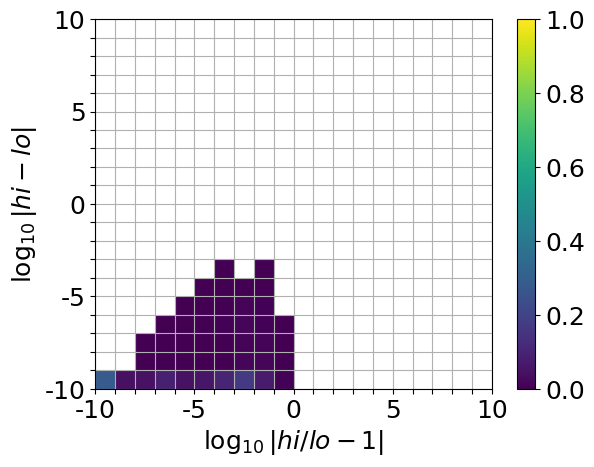

In [25]:
# Setup the check runner and run the check.
check = scale.olm.check.LowOrderConsistency(name='check1',_env=_env,_model=_model,
                        template='model/origami/system-uox.jt.inp', 
                                            nuclide_compare=['pu239','pu240'])
info = check.run(rl)

## Advanced Section
In this section we look at the GridGradient which generates absolute and relative errors of the 

In [26]:
# Save the values of these two attributes to see how changing the grid affects results below.
import copy
coeff = copy.deepcopy(rl.coeff)
time_values = copy.deepcopy(rl.axes_values[2])

In [27]:
# Change nevery to create a coarser grid in burnup. You can come back here and try
# a few versions without running the code above. If you run the line above, your
# saved data will be lost!
nevery = 1 #1=Use every point. Change to 2,3,4, etc. to use fewer points and see the effect on the result.
nbu = time_values.shape[0]
downselect=list(range(0,nbu,nevery))
if downselect[-1]!=nbu-1:
    downselect.append(nbu-1)
    print(downselect)

# Downselect to particular values.
downselect = np.asarray(downselect)
rl.axes_values[2] = time_values[downselect]
#ks=13835
#rl.coeff = coeff[:,:,downselect,ks:ks+1]
rl.coeff = coeff[:,:,downselect,:]

In [8]:
# Do the check.
check2 = scale.olm.check.GridGradient(_env=_env,_model=_model)
info2 = check2.run(rl)

2024-10-30 08:09:28 [info     ] Running GridGradient check with params={"eps0": 1e-20, "epsa": 0.1, "epsr": 0.1, "target_q1": 0.5, "target_q2": 0.7, "nprocs": 3}
2024-10-30 08:09:28 [info     ] Finished computing relative values on axes
2024-10-30 08:09:28 [info     ] Finished reshaping coefficients
2024-10-30 08:09:28 [info     ] Computing grid gradients ...  
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57954/57954 [00:14<00:00, 4057.50it/s]
2024-10-30 08:09:42 [info     ] Finished computing grid gradients
2024-10-30 08:09:42 [info     ] Completed GridGradient with q1=0.80 and q2=0.98


In [9]:
# Give some detailed printout of the GridGradient absolute and relative error metrics
# for a particular parent (pid) and daughter (did) pair.
nd = np.sum( [len(j)-1 for j in rl.axes_values] )
ks=-1
target_pid = 20094239
target_did = 20094240
for k,transition in enumerate(rl.transitions):
    did,tid,pid = transition
    if not(did==target_did and pid==target_pid):
        continue
    ks=k
    n=rl.axes_shape.size
    print(f'k={k:5d} | {did:8d} <-- {tid:4d} -- {pid:8d}')
    for i in range(n):
        print('{:4s}gradients of {:20s}'.format('',rl.axes_names[i]))
        for j in range(len(rl.axes_values[i])-1):
            # Calculate the flat index and print the error metrics.
            iu = k * n * nd + i * nd + j
            print('{:8s}max diff between ({:.1f},{:.1f}) = {:.2e} abs., {:.2e} rel.'.format(
                  '',rl.axes_values[i][j],rl.axes_values[i][j+1],check2.rhist[iu],check2.ahist[iu]))

k=13928 | 20094240 <--  102 -- 20094239
    gradients of enrichment          
        max diff between (4.0,8.5) = 0.00e+00 abs., 0.00e+00 rel.
    gradients of mod_dens            
        max diff between (0.7,0.8) = 0.00e+00 abs., 0.00e+00 rel.
    gradients of times               
        max diff between (0.0,20.0) = 1.27e-06 abs., 2.87e-03 rel.
        max diff between (20.0,540.0) = 8.58e-04 abs., 1.94e+00 rel.
        max diff between (540.0,2020.0) = 5.20e-03 abs., 1.18e+01 rel.
        max diff between (2020.0,4000.0) = 8.83e-05 abs., 2.00e-01 rel.
        max diff between (4000.0,6250.0) = 3.74e-05 abs., 8.45e-02 rel.
        max diff between (6250.0,9000.0) = 3.93e-05 abs., 8.88e-02 rel.
        max diff between (9000.0,12000.0) = 3.29e-05 abs., 7.44e-02 rel.
        max diff between (12000.0,15000.0) = 2.33e-05 abs., 5.28e-02 rel.
        max diff between (15000.0,18000.0) = 1.71e-05 abs., 3.87e-02 rel.
        max diff between (18000.0,21000.0) = 1.28e-05 abs., 2.89e-02 r

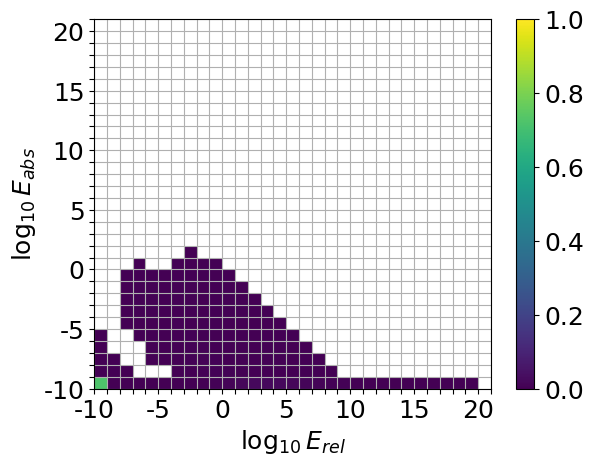

In [10]:
# Show a histogram of relative error (x-axis) and absolute error (y-axis).
# Rolle's Theorem Error Distribution
scale.olm.core.RelAbsHistogram.plot_hist(check2, xlabel=r"$\log_{10} E_{rel}$", ylabel=r"$\log_{10} E_{abs}$")

(2, 2, 32, 57954)


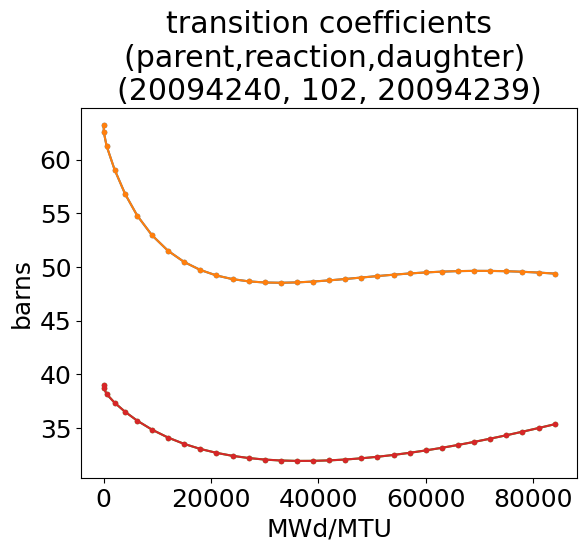

In [11]:
# Plot some transition coefficients for a target transition.
import matplotlib.pyplot as plt
plt.title(f'transition coefficients\n(parent,reaction,daughter) \n{rl.transitions[ks]}')
plt.ylabel('barns')
plt.xlabel('MWd/MTU')
# Iterate through other dimensions.
s = np.shape(rl.coeff)
print(s)
for d1 in range(s[0]):
    for d2 in range(s[1]):
        plt.plot(rl.axes_values[i], rl.coeff[d1,d2,:,ks],'.-')
#plt.xscale('log')
#plt.xlim([0,28000])

In [12]:
#strategy
#1. burnup - calculate ORIGAMI solution at each point in original fine grid
#2. keep only first and last burnups on the coarse grid
#3. using interpolation on the coarse grid, calculate the ORIGAMI solultion at each point in the original fine grid
#4. add back the point that reduces the error the most on the coarse grid
#5. repeat on #3 until error is reasonable